In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv("creditcard.csv")

print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64


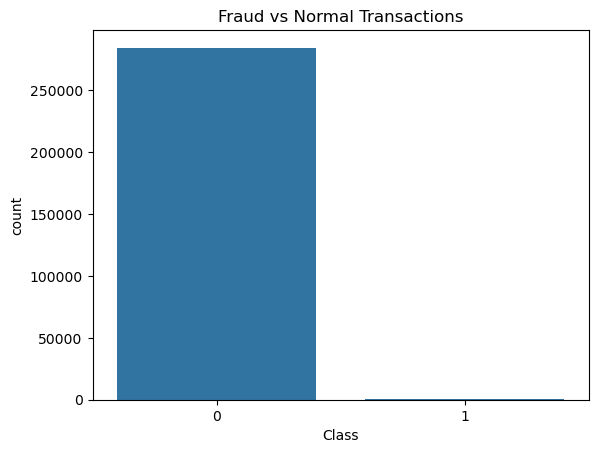

In [3]:
print(df["Class"].value_counts())

sns.countplot(x="Class", data=df)
plt.title("Fraud vs Normal Transactions")
plt.show()


In [4]:
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df[["Amount"]])


In [5]:
df = df.drop("Time", axis=1)


In [6]:
X = df.drop("Class", axis=1)
y = df["Class"]


In [7]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("After SMOTE:", np.bincount(y_resampled))


After SMOTE: [284315 284315]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,
    random_state=42
)


In [10]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, n_jobs=-1),
    "Random Forest": RandomForestClassifier(
        n_estimators=60,      # reduced from 120
        max_depth=12,         # limit tree depth
        n_jobs=-1,
        random_state=42
    )
    # removed Gradient Boosting (slow)
}

trained_models = {}

for name, model in models.items():
    print("Training:", name)
    model.fit(X_train, y_train)
    trained_models[name] = model

print("Done training.")


Training: Logistic Regression
Training: Random Forest
Done training.


In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_resampled,
        y_resampled,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1
    )
    print(f"{name} ROC-AUC: {scores.mean():.4f}")

Logistic Regression ROC-AUC: 0.9890
Random Forest ROC-AUC: 0.9999



 Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     56863
           1       0.97      0.92      0.94     56863

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726



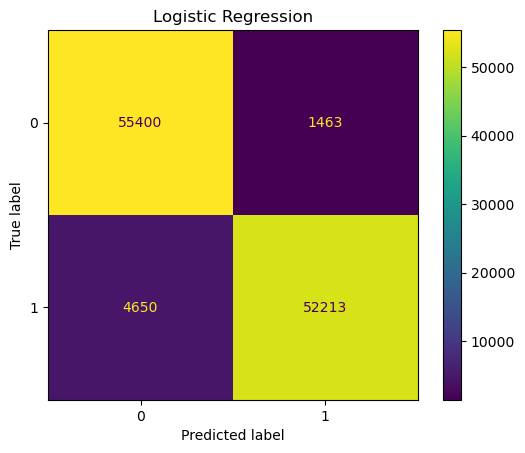


 Random Forest
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     56863
           1       1.00      0.99      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



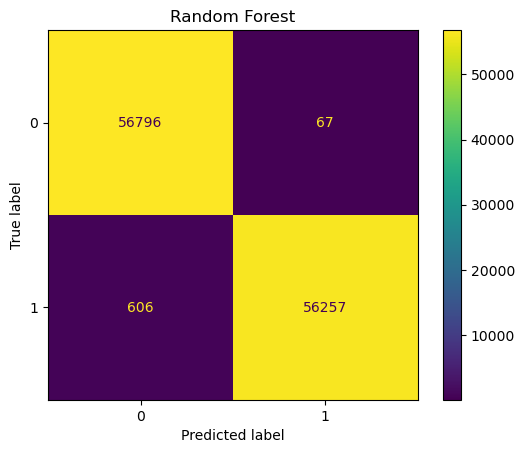


Model ROC-AUC summary:
Logistic Regression : 0.9892
Random Forest : 0.9999


In [12]:
results = []

for name, model in trained_models.items():
    probs = model.predict_proba(X_test)[:,1]
    preds = model.predict(X_test)

    auc = roc_auc_score(y_test, probs)

    print("\n", name)
    print(classification_report(y_test, preds))

    results.append((name, auc))

    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title(name)
    plt.show()

print("\nModel ROC-AUC summary:")
for r in results:
    print(r[0], ":", round(r[1],4))


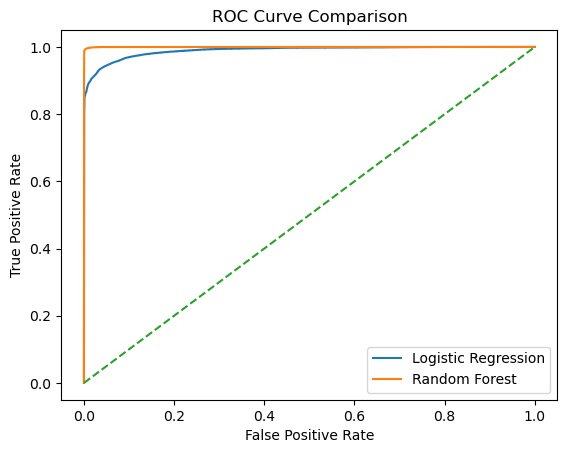

In [13]:
plt.figure()

for name, model in trained_models.items():
    probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


Threshold: 0.7
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     56863
           1       1.00      0.98      0.99     56863

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726



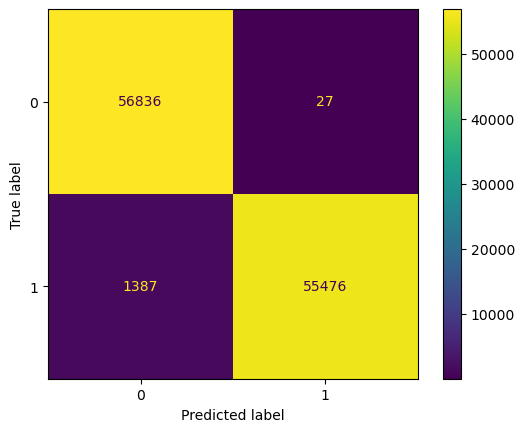

In [14]:
rf = trained_models["Random Forest"]

probs = rf.predict_proba(X_test)[:,1]

threshold = 0.7
custom_preds = (probs > threshold).astype(int)

print("Threshold:", threshold)
print(classification_report(y_test, custom_preds))

ConfusionMatrixDisplay.from_predictions(y_test, custom_preds)
plt.show()


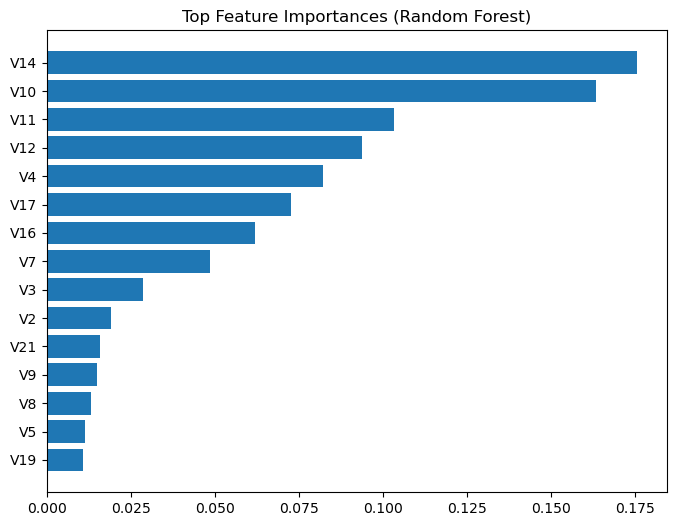

In [15]:
rf = trained_models["Random Forest"]

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top Feature Importances (Random Forest)")
plt.show()


In [16]:
import joblib
joblib.dump(rf, "fraud_model.pkl")


['fraud_model.pkl']